Морфологический анализ <br/>
Домашнее задание 8 <br/>
**Голев Александр 135М**

# Исследовать помехозащищенность морфологических методов идентификации 
на примере задачи идентификации цифр 0, 1, . . . , 9 по их изображениям, пораженным слу-
чайным попиксельно независимым аддитивным шумом.


### 1. Построить абсолютные формы $L_i$ цифр i = 0, 1, . . . , 9    как формы изображений с двумя областями постоянной яркости;

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import func as f
import mosaic_approx as ma
import noise_gen as ns
import old_finder as of

In [2]:
# Загружаем изображение
samples = []
samples_bin = []
for number in range(10):
    image = cv2.imread(f'samples/c_{number}.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    samples.append(gray_image)
    _, image_bin = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    samples_bin.append(image_bin)

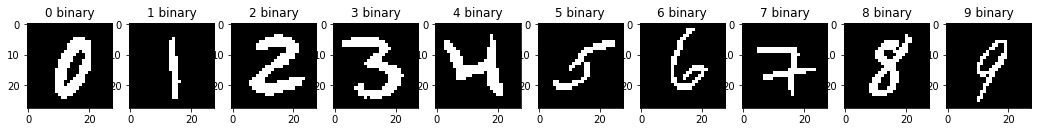

In [5]:
f.showOneLine(samples_bin,[str(x)+' binary' for x in range(10)],dim = 10)

Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.
Уровни квантования: 2
.


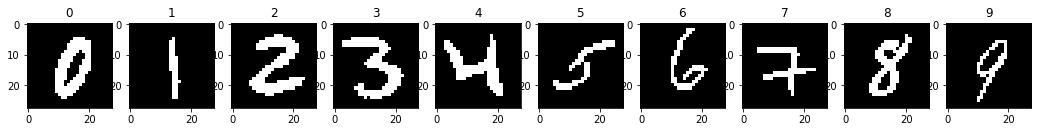

In [6]:
sample_fs, sample_msks, sample_lvls = [],[],[]
for number in range(10):
    fr, m, l  = ma.relaxation(samples_bin[number], threshold=0, N=1)
    sample_fs.append(fr[0])
    sample_msks.append(m[0])
    sample_lvls.append(l[0])
    
f.showOneLine(sample_fs, [str(x) for x in range(len(sample_fs))], dim = 10)

### Q_i - это проектор, который проецирует на всевозможные области пресесечений каких угодно чисел, где нет областей, связанных с i -м числом

In [7]:
h, w = samples[0].shape

fields = np.empty((h, w), dtype=str)
fields = fields.astype('<U11')
for number, img in enumerate(samples_bin):
    for i in range(h):
        for j in range(w):        
            if img[i, j] == 255:
                fields[i, j]+=str(number)


In [105]:
# Уникальные комбинации цифр, существубщие для наших картинок
uniq_fields = [f for f in np.unique(fields) if len(f) > 0]

# Маски для каждой уникальной комбинации
uniq_masks = {}
for field in np.unique(fields):
    uniq_masks[field]= np.where(fields==field, 0, 255)

# Набор уникальных комбинаций без определенной цифры
fields_without_number = {}
for i in range(10):
    fields_without_number[i] = [x for x in uniq_fields if str(i) not in x]

# Numpy True/False маски для каждого уникального набора цифр
array_mask = {}
for field in uniq_fields:
   array_mask[field] = (fields == field) 


In [ ]:

f.showOneLine([255 - uniq_masks[field].astype(np.uint8) for field in uniq_fields],[x for x in uniq_fields],dim = 15,size=(24,36))


In [108]:
def Q(number, g):
    result = np.zeros(g.shape)
    for field in fields_without_number[number]:
        result[array_mask[field]] = np.ma.array(g, mask=uniq_masks[field]).mean()
    mask = np.logical_or(fields=='' , samples_bin[number]==255)
    result[mask] =  np.ma.array(g, mask=mask).mean()  
    return result

### Функция определения цифры

In [133]:
def findDigit(g, samples):
    min_diff = float('inf')
    result = 0
    imgs,diffs = [],[]
    
    for i in range(10):
        proj_img =  Q(i, g)
        diff =  np.square(np.linalg.norm(proj_img))
       
        if diff < min_diff:
            result = i
            min_diff = diff
        imgs.append(proj_img)
        diffs.append(diff)
    
    return result, imgs, diffs

## Подсчеты ошибок с выборки

In [32]:
sigmas = [0,100,150,175,187,200,210,215,220,225,230,235,240,245,250,255]

In [30]:
def calculation(findDigit, *args, length = 100):
    errors =  []
    confusion_matrix = np.zeros((10,10))
    # проходимся по каждому отклонению
    for sigma in sigmas:
        print('.',end='')
        error = 0
        #по каждой цифре
        for digit, dig_img in enumerate(samples):
            # выборка 100 для каждой цифры
            for tmp_img in ns.genNoises(dig_img, sigma, length = length):
                # если ошиблись, считаем ошибку
                result = findDigit(tmp_img, *args)[0]
                
                if (sigma == 240):
                        confusion_matrix[digit,result]+=1
                        
                if digit != result:
                    error +=1
                    
        errors.append(error)
     

    errors = np.array(errors)
    return errors, confusion_matrix

In [84]:
errors1, confusion_matrix1 = calculation(of.findDigit, samples_bin,True)

..

c:\Users\golev\source\repos\!Python programs\MAGA1\Morph Analysis\8-task\old_finder.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


..............

In [85]:
errors2, confusion_matrix2 = calculation(of.findDigit, samples_bin,False)

................

In [134]:
errors3, confusion_matrix3 = calculation(findDigit, samples_bin, length=10)

................

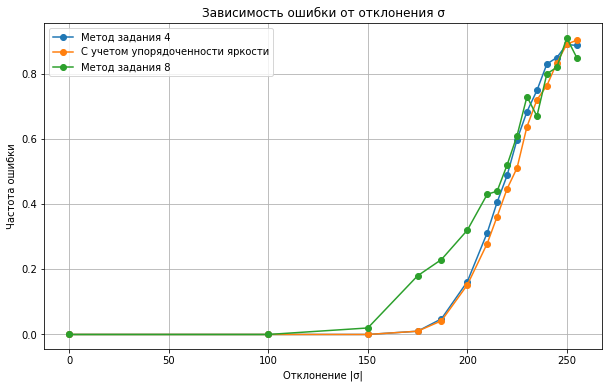

In [135]:
plt.figure(figsize=(10, 6))
plt.plot(sigmas, errors1/1000, marker='o', linestyle='-',label="Метод задания 4")
plt.plot(sigmas, errors2/1000, marker='o', linestyle='-',label="С учетом упорядоченности яркости")
plt.plot(sigmas, errors3/100, marker='o', linestyle='-',label="Метод задания 8")
plt.xlabel('Отклонение |σ|')
plt.ylabel('Частота ошибки')
plt.title('Зависимость ошибки от отклонения σ')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
def colorized(confusion_matrix, ax):
    alpha = [str(x) for x in range(10)]
    xaxis = np.arange(len(alpha))
    ax.matshow(confusion_matrix/100, cmap=plt.cm.Blues)
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(alpha)
    ax.set_yticklabels(alpha)
    for i in range(10):
        for j in range(10):
            c = confusion_matrix[j,i]/100
            ax.text(i, j, str(c), va='center', ha='center')

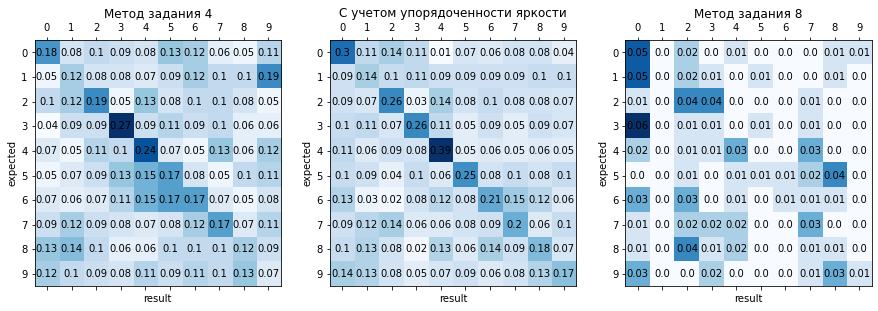

In [136]:
plt.figure(figsize=(15, 8))
text = ['Метод задания 4', 'С учетом упорядоченности яркости','Метод задания 8']
for number in range(3):
    ax =plt.subplot(1, 3, number+1)
    plt.title(text[number])
    plt.xlabel('result')

    plt.ylabel('expected')

    colorized([confusion_matrix1,confusion_matrix2,confusion_matrix3][number], ax)
    

   

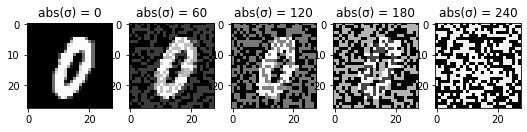

In [131]:
noise_examples = []
digit_samle = samples[0]  # Выберите случайную цифру из исходных
tmp_mlt = 60
for i in range(5):
    sigma = i*tmp_mlt  # Отклонение
    noise_examples.append( ns.addNoise(digit_samle,abs_sigma = i*tmp_mlt))
    
f.showOneLine(noise_examples,[f'abs(σ) = {x*tmp_mlt}' for x in range(10)], dim = 10)

Result - 0


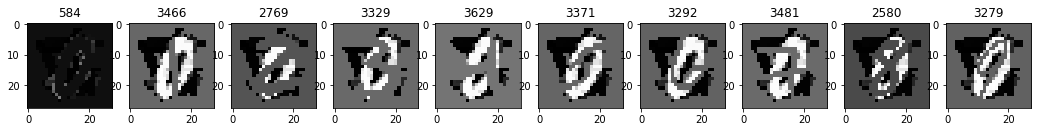

Result - 0


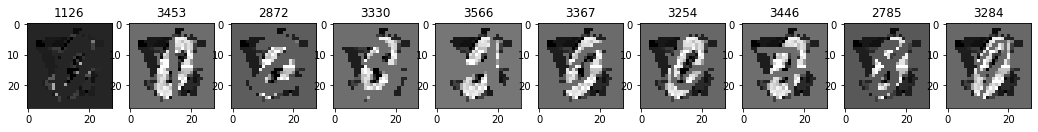

Result - 0


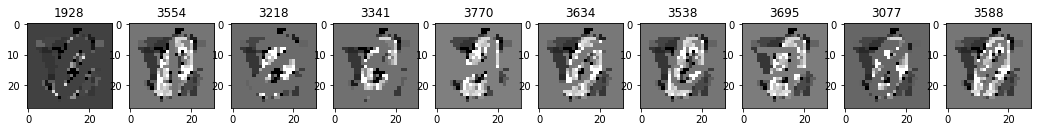

Result - 0


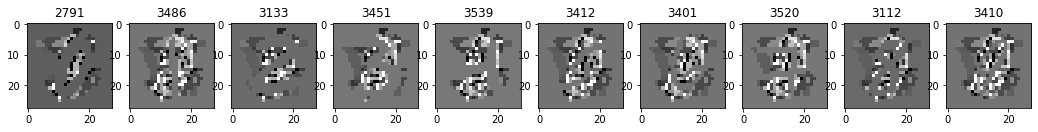

Result - 5


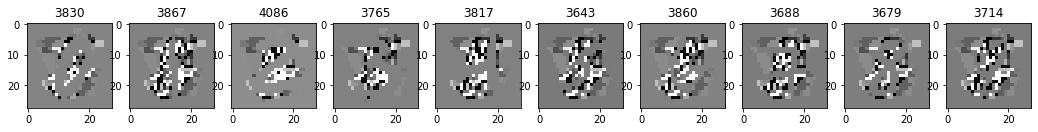

In [132]:
for image in noise_examples:
    result, imgs, diffs = findDigit(image, samples)
    print(f'Result - {result}')
    f.showOneLine([i.astype(np.uint8 )for i in imgs],[str(int(x)) for x in diffs], dim = 10)